In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Generators

A generator is a function that generates values in a sequence under demand. It is based on using the `yield` keyword instead of `return`. Everytime we call the generator function, the next value in the sequence is generated and return. If we had to do the same with a normal function, we would have to generate (and therefore allocate memory for) all the elements of the sequence before returning it. Therefore, generators are usually much more memory efficient that normal sequence generating functions (as long as the memory require to keep the state of the generator is much large than actually producing the whole sequence.)

The two following functions do the same, but the generator version one requires much less memory:

In [2]:
def fibonacci():
    i, j = 1, 1
    ret = []
    while j < 50:
        ret.append(i)
        i, j = j, i + j
    return ret


for f in fibonacci():
    print(f)

1
1
2
3
5
8
13
21


In [3]:
def fibonacci_generator():
    i, j = 1, 1
    while j < 50:
        yield i
        i, j = j, i + j

for f in fibonacci_generator():
    print(f)

1
1
2
3
5
8
13
21


We could also define a generator that returns an infinite series:

In [4]:
def fibonacci_generator_2():
    i, j = 1, 1
    while True:
        yield i
        i, j = j, i + j
        
for f in fibonacci_generator_2():
    print(f)
    if f >= 20:
        break

1
1
2
3
5
8
13
21


## Itertools

However, generators cannot be indexed, and this may make some operations with them complex, unless we use the `itertools` package. This package allows us to do operations with generators that we can usually do with lists, like selecting or applying operations on a subset of values in the sequence.

This can be useful to process data that does not fit in memory. For instance, let's assume that we are interested in  applying anomaly detection to a time series stored in a file. Each row of the file represents a point in the time series represented as a (timestamp, value) pair. Let's assume that we can not store the whole file into our computer's memory.

The following function simulates a generator that returns the sequence of points in the file:

In [5]:
np.random.seed(0)

MU = 10
SIGMA = 10

def read_filename(filename):
    # filename is the file from which we are reding the data.
    # This function produces fake infinite data, and no file is read, so this
    # parameter is actually not used. 
    i = 0
    while True:
        yield (i, np.random.randn() * SIGMA + MU)
        i = i + 1

We can, for instance, generate the first 100 elements of the sequence:

Text(0,0.5,'value')

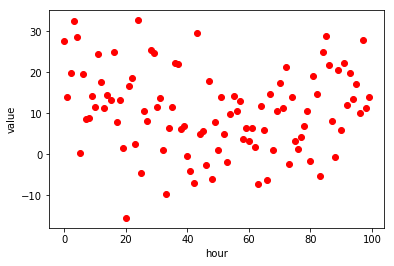

In [6]:
fig, ax = plt.subplots()
for i in itertools.takewhile(lambda x: x[0] < 100, read_filename('file.txt')):
    ax.plot(i[0], i[1], 'ro')
ax.set_xlabel('hour')
ax.set_ylabel('value')

The type of anomaly detection we are implementing is based on a rolling window. If each row in the file represents an hour, we calculate anomalies by computing a mean and standard deviation value each day. The following function returns non-overlapping 24 hour windows: 

In [7]:
def day_grouper(iterable):
    key = lambda x: x[0] // 24
    return itertools.groupby(iterable, key)

In [8]:
for i in itertools.takewhile(lambda x: x[0] < 5, day_grouper(read_filename('file.txt'))):
    print(i)

(0, <itertools._grouper object at 0x1183c0c18>)
(1, <itertools._grouper object at 0x118416550>)
(2, <itertools._grouper object at 0x1184164e0>)
(3, <itertools._grouper object at 0x118416550>)
(4, <itertools._grouper object at 0x1184164e0>)


This is the function that works over the groups to detect anomalies. It returns False if no anomaly was found that day, and the day itself otherwise. 

In [9]:
def check_anomalies(x):
    day = x[0]
    day_data = x[1]
    
    n = 0
    mean = 0
    M2 = 0
    max_value = -math.inf
    values = []
    for d in day_data:
        value = d[1]
        values.append(value)
        n += 1
        delta = value - mean
        mean = mean + delta / n
        M2 += delta * (value - mean)
        max_value = max(max_value, value)
    variance = M2 / (n - 1)
    sd = math.sqrt(variance)
    
    if max_value > mean + 3 * sd:
        return (day, max_value, mean, sd)
    return False

And in here we return the 10 first days for which an anomaly exists. The `itertools` module does not have the `ifilter` and `imap` functions in Python 3. Therefore, we are using the base `map` and `filter` functions. 

In [10]:
i = 0
for anomaly in filter(None, map(check_anomalies, day_grouper(read_filename('file.txt')))):
    day = anomaly[0]
    max_value = anomaly[1]
    mean = anomaly[2]
    sd = anomaly[3]
    lower = mean - 3 * sd
    upper = mean+ 3 * sd
 
    print('Day ' + str(day) + ': value ' + str(max_value) + ' is not in the [' + str(lower) + ', ' + str(upper) + '] range')
    
    i = i + 1
    if i == 10:
        break

Day 52: value 36.805708407690005 is not in the [-13.851068277459605, 36.52864532575363] range
Day 143: value 35.481126978151906 is not in the [-20.279855334618624, 34.7548953410301] range
Day 236: value 34.6539649698735 is not in the [-13.141146509689502, 30.957391738306985] range
Day 297: value 42.118474715250485 is not in the [-21.660317395264435, 41.66203120173913] range
Day 298: value 40.03123295365933 is not in the [-14.8039556357806, 38.74453437320885] range
Day 326: value 35.42334601099513 is not in the [-13.339067897267908, 35.04079484187493] range
Day 329: value 40.196695959522884 is not in the [-18.329486443656094, 37.89082109406752] range
Day 346: value 36.15180689057667 is not in the [-11.931291018289217, 35.17884968868242] range
Day 439: value 44.57178892744014 is not in the [-18.423357833318608, 40.325782485334585] range
Day 469: value 44.915503643833446 is not in the [-21.75955262837085, 40.48794689717538] range
